# Summary

Reference: https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/

## Step 0 - Load the env and connect with an LLM

In [1]:
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())
openai_api_key = os.environ["OPENAI_API_KEY"]

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

## Step 1 - Define a tool using tavily_search

Note you will need a tavily api by signing up for their free account.

Free usage limit is 1000 api call per month

In [5]:
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search_tool = TavilySearchResults(max_results=2)
tools = [tavily_search_tool]

## Step 2 - Create agent using LangGraph prebuilt agent

In [7]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, tools)

### Step 2 - 1 Try visualize the graph 

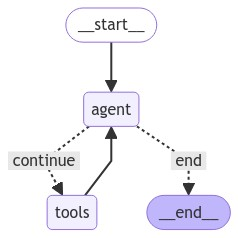

In [8]:
from IPython.display import Image, display

display(Image(agent_executor.get_graph().draw_mermaid_png()))

In [9]:
# Create helper function to print neatly the conversation
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

## Step 3 - Try call the app with an input that needs a tool call

In [10]:
inputs = {"messages": [("user", "what is the weather in seattle")]}
print_stream(agent_executor.stream(inputs, stream_mode="values"))

================================ Human Message =================================

what is the weather in seattle
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_1pBZAcZvB1D875q1VfHyLfZM)
 Call ID: call_1pBZAcZvB1D875q1VfHyLfZM
  Args:
    query: current weather in Seattle
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'Seattle', 'region': 'Washington', 'country': 'United States of America', 'lat': 47.61, 'lon': -122.33, 'tz_id': 'America/Los_Angeles', 'localtime_epoch': 1725484207, 'localtime': '2024-09-04 14:10'}, 'current': {'last_updated_epoch': 1725483600, 'last_updated': '2024-09-04 14:00', 'temp_c': 22.8, 'temp_f': 73.0, 'is_day': 1, 'condition': {'text': 'Sunny', 'icon': '//cdn.weatherapi.com/weather/64x64/day/113.png', 'code': 1000}, 'wind_mph': 5.6, 'wind_kph

## Step 3-1 Trying question that dont need tool

In [11]:
inputs = {"messages": [("user", "what is your name?")]}
print_stream(agent_executor.stream(inputs, stream_mode="values"))

================================ Human Message =================================

what is your name?
================================== Ai Message ==================================

I don't have a personal name, but you can call me Assistant! How can I help you today?


## Step 4 - Adding a memory
This is done by adding a checkpointer to create_react_agent function

In [2]:
# Grouping the code from the beginning
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import create_react_agent

# Create model
model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Prepare search_tool
tavily_search_tool = TavilySearchResults(max_results=2)
tools = [tavily_search_tool]

# Prepare memory
memory = MemorySaver()

# Use them together to build the graph node
weather_agent=create_react_agent(model, tools=tools, checkpointer=memory)

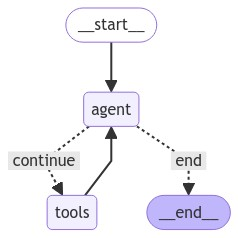

In [3]:
# Prepare for visualization
from IPython.display import Image, display

# Check the graph built. It should look the same as previous, the checkpointer is not shown here
display(Image(weather_agent.get_graph().draw_mermaid_png()))

# Create helper function to print neatly the conversation
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

# We need a config to store the session id
config = {"configurable": {"thread_id": "1"}}

Now we will ask the first question as before

In [18]:
inputs = {"messages": [("user", "what is the weather in seattle")]}
# Note we added the config to identify the session
print_stream(weather_agent.stream(inputs, config=config, stream_mode="values"))

================================ Human Message =================================

what is the weather in seattle
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_jR5oJFt0aH4D4VAK9PeyPc6d)
 Call ID: call_jR5oJFt0aH4D4VAK9PeyPc6d
  Args:
    query: current weather in Seattle
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'Seattle', 'region': 'Washington', 'country': 'United States of America', 'lat': 47.61, 'lon': -122.33, 'tz_id': 'America/Los_Angeles', 'localtime_epoch': 1725486508, 'localtime': '2024-09-04 14:48'}, 'current': {'last_updated_epoch': 1725486300, 'last_updated': '2024-09-04 14:45', 'temp_c': 23.3, 'temp_f': 73.9, 'is_day': 1, 'condition': {'text': 'Sunny', 'icon': '//cdn.weatherapi.com/weather/64x64/day/113.png', 'code': 1000}, 'wind_mph': 8.1, 'wind_kph

Lets try to ask a follow up question

In [19]:
inputs = {"messages": [("user", "what activities can we do with this kind of weather?")]}
# Note we need the config to identify the session
print_stream(weather_agent.stream(inputs, config=config, stream_mode="values"))

================================ Human Message =================================

what activities can we do with this kind of weather?
================================== Ai Message ==================================

With sunny weather and mild temperatures around 23.3°C (73.9°F), Seattle offers a variety of outdoor activities. Here are some suggestions:

1. **Visit Parks**: Explore local parks like Discovery Park or Volunteer Park for walking, picnicking, or enjoying the scenery.

2. **Water Activities**: Consider kayaking or paddleboarding on Lake Union or Puget Sound.

3. **Hiking**: Take advantage of the pleasant weather to hike nearby trails, such as those in the Cascade Mountains or Mount Rainier National Park.

4. **Outdoor Dining**: Enjoy a meal at one of Seattle's many outdoor cafes or restaurants with patios.

5. **Biking**: Rent a bike and ride along the Burke-Gilman Trail or through the city.

6. **Visit the Waterfront**: Stroll along the Seattle waterfront, visit the Seatt

## Step 5 Further investigation 

We want to check the output returned when calling the weather_agent.stream() method. 

In [5]:
inputs = {"messages": [("user", "what is the weather in seattle")]}
output = weather_agent.stream(inputs, config=config, stream_mode="values")

In [7]:
print(output)
def investigate_stream(stream):
    for s in stream:
        print(type(s))
        print(s)
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            print(type(message))
            message.pretty_print()
investigate_stream(output)

<generator object Pregel.stream at 0x0000018510DB07C0>
<class 'langgraph.pregel.io.AddableValuesDict'>
{'messages': [HumanMessage(content='what is the weather in seattle', id='1a99cb1c-0bea-4a91-9625-c747f9a7dbe8')]}
<class 'langchain_core.messages.human.HumanMessage'>
================================ Human Message =================================

what is the weather in seattle
<class 'langgraph.pregel.io.AddableValuesDict'>
{'messages': [HumanMessage(content='what is the weather in seattle', id='1a99cb1c-0bea-4a91-9625-c747f9a7dbe8'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_sc7GisDI4IIOG2ucPmnmXtAZ', 'function': {'arguments': '{"query":"current weather in Seattle"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 86, 'total_tokens': 107}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_483d39d857', 'finish_reason': 'tool_calls', 